In [ ]:
#Mounting Drive and Uploading Datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

fraudData = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')


In [ ]:
fraudData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print("Dataset shape:", fraudData.shape)  # Rows and columns
print("Data Types:\n", fraudData.dtypes)
print("Missing Values:\n", fraudData.isnull().sum())
print("Missing Percentage:\n", (fraudData.isnull().sum() / len(fraudData)) * 100)
print("Duplicate Rows:", fraudData.duplicated().sum())

Dataset shape: (284807, 31)
Data Types:
 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object
Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     

In [ ]:
fraudData.drop_duplicates(inplace=True)
print("Class Distribution:\n", fraudData['Class'].value_counts())
print("Class Proportions (%):\n", fraudData['Class'].value_counts(normalize=True) * 100)

Class Distribution:
 Class
0    283253
1       473
Name: count, dtype: int64
Class Proportions (%):
 Class
0    99.83329
1     0.16671
Name: proportion, dtype: float64


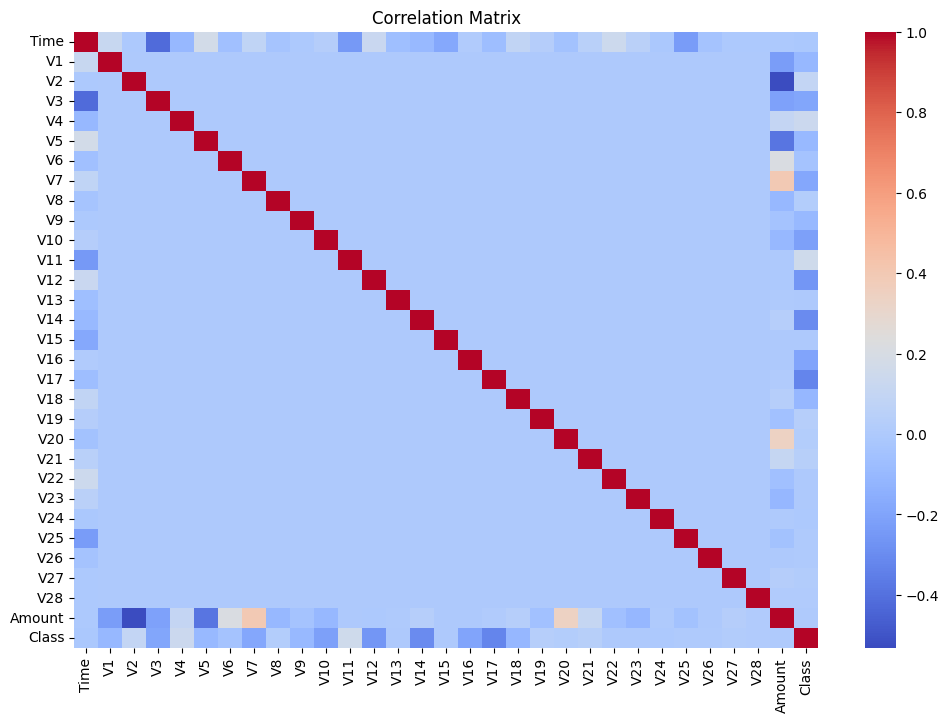

Highly correlated features to drop: set()


In [ ]:
#Feature Selection
# Calculate correlation matrix
correlation_matrix = fraudData.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Remove features with high correlation (threshold: 0.9)
correlated_features = set()
correlation_threshold = 0.9
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

print(f"Highly correlated features to drop: {correlated_features}")

# Drop correlated features
fraudData.drop(columns=correlated_features, inplace=True)

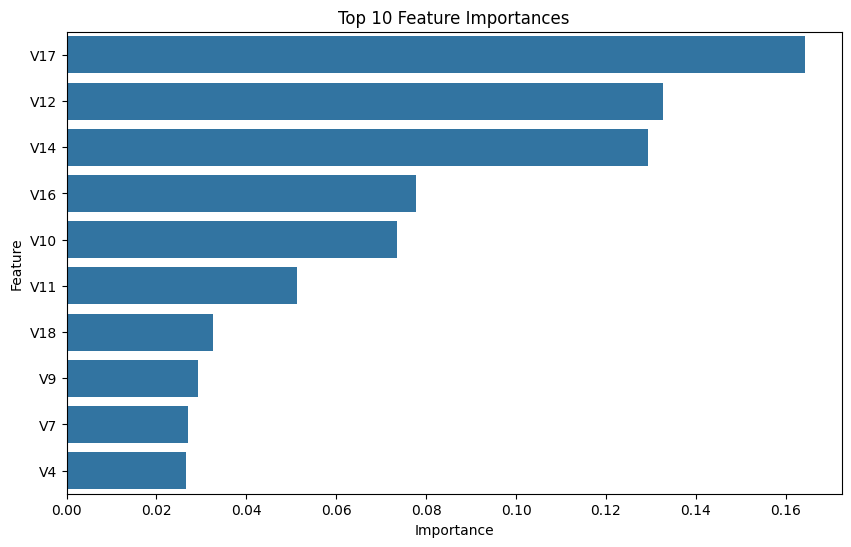

In [ ]:
# Split the data into features and target
X = fraudData.drop('Class', axis=1)
y = fraudData['Class']

# Train a Random Forest to get feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances")
plt.show()

# Keep only important features (threshold: 0.01)
important_features = feature_importances[feature_importances['Importance'] > 0.01]['Feature']
X = X[important_features]

In [ ]:
# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())

Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
from imblearn.combine import SMOTETomek

# Apply SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_balanced, y_balanced = smote_tomek.fit_resample(X, y)

print("Class distribution after SMOTE + Tomek:")
print(y_balanced.value_counts())

In [ ]:
#Cross-Validation Function
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
def cross_validate_model(model, X, y, cv=5):
    """Perform cross-validation and return mean scores."""
    scoring = {'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}
    cv_results = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42), scoring='roc_auc')
    print(f"Cross-Validation ROC-AUC: {np.mean(cv_results):.4f} ± {np.std(cv_results):.4f}")
    return np.mean(cv_results)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve and AUC Score
    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        print(f"\nAUC Score: {auc:.4f}")

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation ROC-AUC: 0.9980 ± 0.0001

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.15      0.86      0.26        95

    accuracy                           0.99     56746
   macro avg       0.58      0.93      0.63     56746
weighted avg       1.00      0.99      0.99     56746


AUC Score: 0.9621


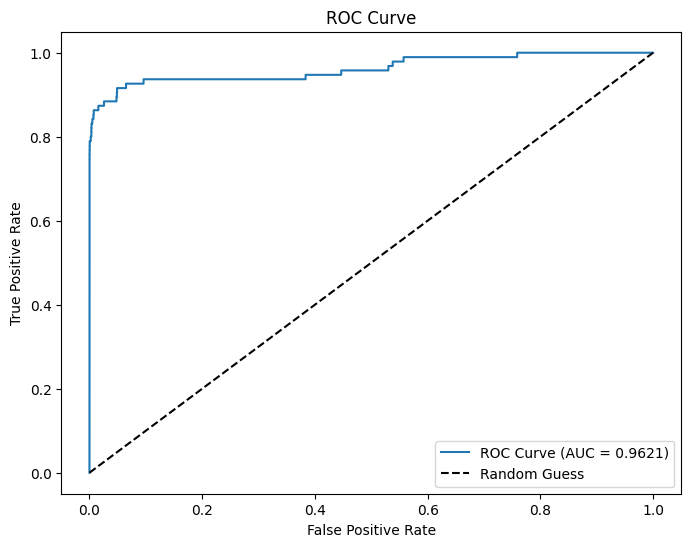

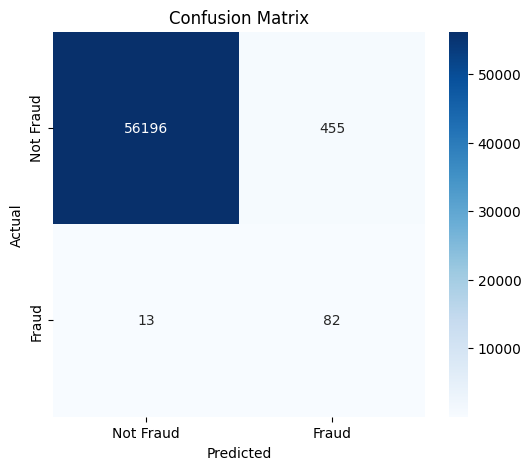

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
logistic_model.fit(X_train_balanced, y_train_balanced)

# Cross-Validation
cross_validate_model(logistic_model, X_train_balanced, y_train_balanced)

# Evaluation
evaluate_model(logistic_model, X_train_balanced, y_train_balanced, X_test, y_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}],  # Class weights
    'solver': ['lbfgs', 'liblinear', 'saga']  # Solvers
}

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=5000, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic_model, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Use the best model for evaluation
best_logistic_model = grid_search.best_estimator_
evaluate_model(best_logistic_model, X_train_balanced, y_train_balanced, X_test, y_test)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

Optimal Threshold: 0.23

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56648
           1       1.00      0.81      0.89        98

    accuracy                           1.00     56746
   macro avg       1.00      0.90      0.95     56746
weighted avg       1.00      1.00      1.00     56746


AUC Score: 1.0000


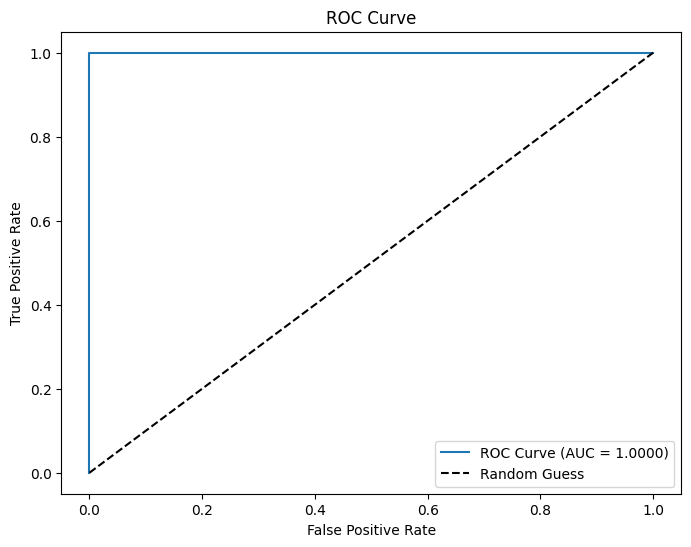

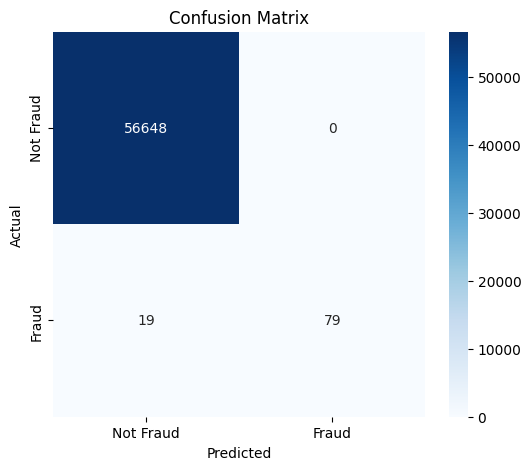

In [ ]:
from sklearn.metrics import precision_recall_curve

# Get the feature names from the trained model
training_features = best_logistic_model.feature_names_in_

# Ensure X_test has all the training features in the correct order
X_test = X_test.reindex(columns=training_features, fill_value=0)

y_pred_proba = best_logistic_model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that gives the highest F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_threshold}")

# Adjust predictions using the optimal threshold
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the model with the adjusted threshold
evaluate_model(model, X_train_balanced, y_train_balanced, X_test, y_pred_adjusted)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.85      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962


AUC Score: 0.9635


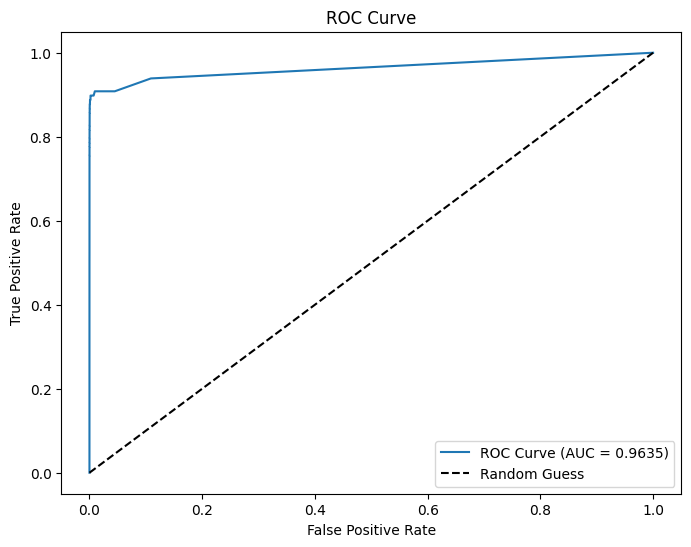

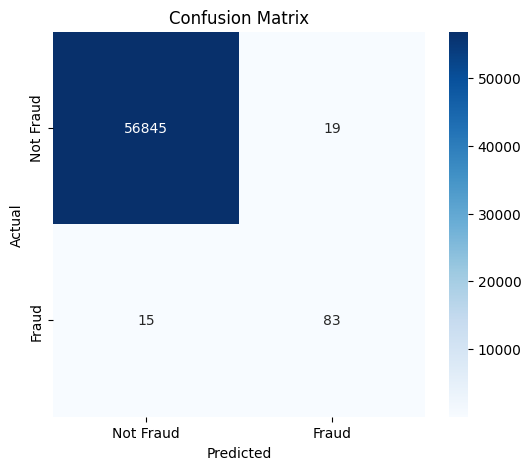

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Cross-Validation


# Get the feature names from the trained model
training_features = rf_model.feature_names_in_

# Ensure X_test has all the training features in the correct order
X_test = X_test.reindex(columns=training_features, fill_value=0)

# Evaluation
evaluate_model(rf_model, X_train_balanced, y_train_balanced, X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56666
           1       1.00      1.00      1.00        80

    accuracy                           1.00     56746
   macro avg       1.00      1.00      1.00     56746
weighted avg       1.00      1.00      1.00     56746


AUC Score: 1.0000


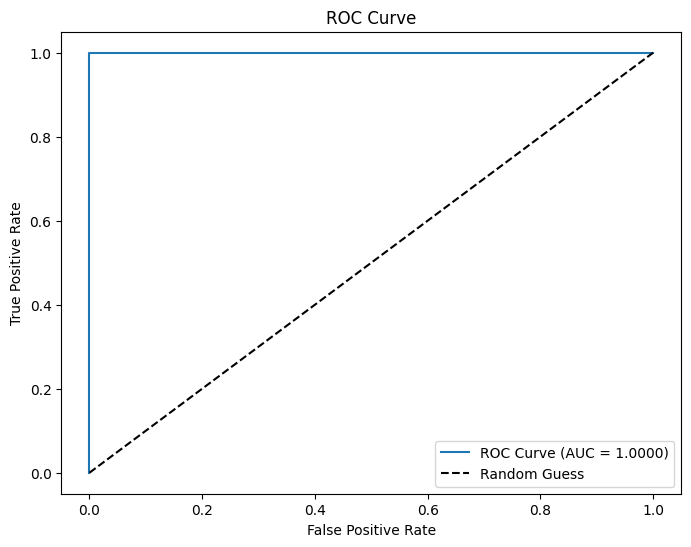

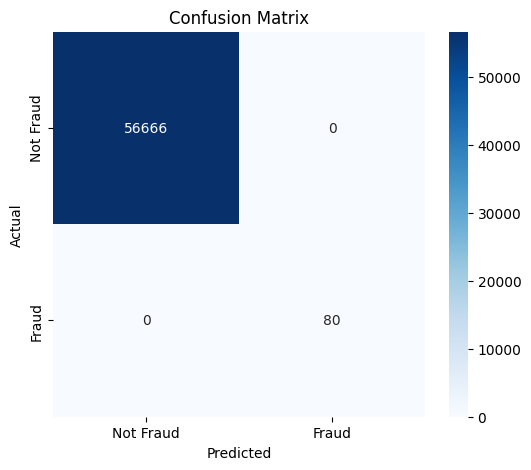

In [ ]:
# Get prediction probabilities
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Set a custom threshold (e.g., 0.7)
threshold = 0.50
y_pred_custom = (y_proba >= threshold).astype(int)

# Evaluate with custom predictions
# Evaluation
evaluate_model(rf_model, X_train_balanced, y_train_balanced, X_test, y_pred_custom)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:04:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.81      0.80      0.80        95

    accuracy                           1.00     56746
   macro avg       0.90      0.90      0.90     56746
weighted avg       1.00      1.00      1.00     56746


AUC Score: 0.9548


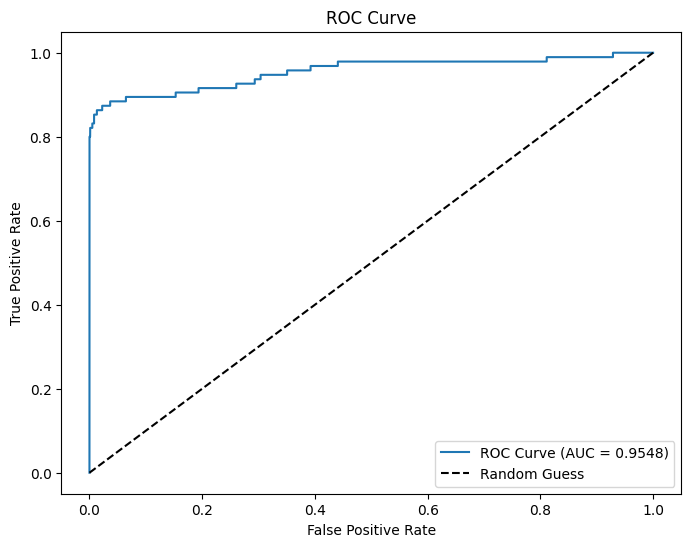

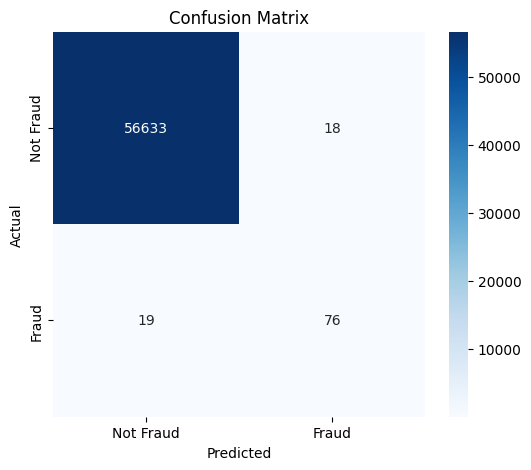

In [ ]:
# XGBoost
from xgboost import XGBClassifier

scale_pos_weight = len(y_train_balanced[y_train_balanced == 0]) / len(y_train_balanced[y_train_balanced == 1])
scale_pos_weight *= 0.9
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=6,               # Try reducing from default 6 to 4-5
    min_child_weight=5,        # Increase for more conservative splits
    gamma=0.2,                 # Add minimum loss reduction
    subsample=0.8,             # Use a subset of data
    colsample_bytree=0.8       # Use a subset of features
)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Cross-Validation
#cross_validate_model(xgb_model, X_train_balanced, y_train_balanced)

# Get the feature names from the trained model
training_features = xgb_model.feature_names_in_

# Ensure X_test has all the training features in the correct order
X_test = X_test.reindex(columns=training_features, fill_value=0)

# Evaluation
evaluate_model(xgb_model, X_train_balanced, y_train_balanced, X_test, y_test)

In [ ]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)


# Get the feature names from the trained model
training_features = svm_model.feature_names_in_

# Ensure X_test has all the training features in the correct order
X_test = X_test.reindex(columns=training_features, fill_value=0)

# Evaluation
evaluate_model(svm_model, X_train_balanced, y_train_balanced, X_test, y_test)
